In [87]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance as EMD

In [13]:
data = np.genfromtxt('./data/Rayleigh_P30_downsampled_flat.csv',delimiter=',',skip_header=True)
cord = np.genfromtxt('./data/downsampled_points.csv',delimiter=',',skip_header=True)
avg = np.mean(data,axis=0)

In [14]:
data.shape

(15400, 2382)

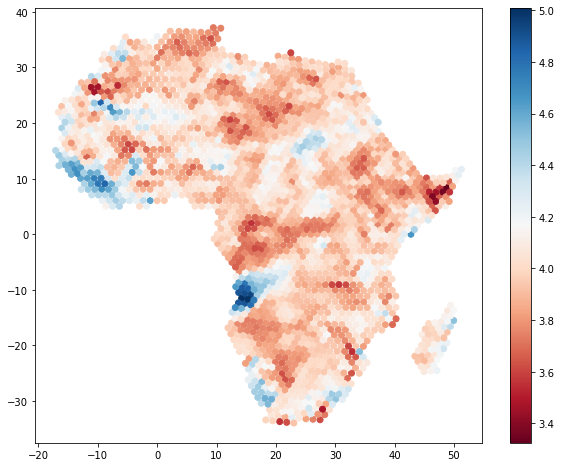

In [18]:
fig = plt.figure(figsize=(10,8))
plt.scatter(cord[:,0],cord[:,1],c=avg,cmap='RdBu')
plt.colorbar()
plt.show()

In [98]:
import torch
from generative_model import *

model = WGAN_SIMPLE(ndim=2382)
checkpoint = torch.load('./model/WGAN_Simple_epoch190.model')
model.load_state_dict(checkpoint["model_state_dict"])

fake_data = model.gen(torch.randn(128, model.nlatent, device="cpu")).detach().numpy()

In [99]:
# generate 10,000 mcmc samples using trained WGAN
fake_data = np.zeros((100000,2382))
for i in range(1000):
    left_idx = 100 * i
    right_idx = 100 * (i+1)
    fake_data[left_idx:right_idx,:] = model.gen(torch.randn(100, model.nlatent, device="cpu")).detach().numpy()
fake_avg = np.mean(fake_data,axis=0)

In [100]:
# load the scalar
scaler_file = open('./data/whole_scaler.pkl', 'rb')
scaler = pickle.load(scaler_file)

/var/folders/hf/j0cnbrtd4fbcfm7nf1yyzbf40000gn/T/ipykernel_94530/3219833920.py:8: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


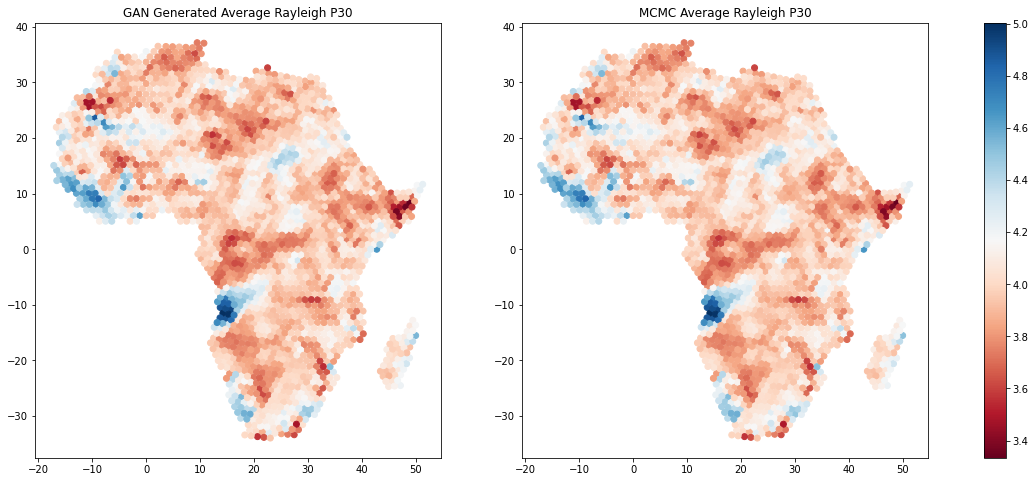

In [101]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
axes = axes.flatten()
fig_fake = axes[0].scatter(cord[:,0],cord[:,1],c=scaler.inverse_transform(fake_avg),cmap='RdBu')
axes[0].set_title('GAN Generated Average Rayleigh P30')
fig_real = axes[1].scatter(cord[:,0],cord[:,1],c=avg,cmap='RdBu')
axes[1].set_title('MCMC Average Rayleigh P30')
plt.colorbar(fig_fake,ax=axes)
plt.show()

In [102]:
# compare the difference between the averages
gan_average_scaled = scaler.inverse_transform(fake_avg)
diff = np.sum(np.absolute(gan_average_scaled-avg))
diff/2382

0.006762929607912862

In [103]:
fake_data_scaled = scaler.inverse_transform(fake_data)

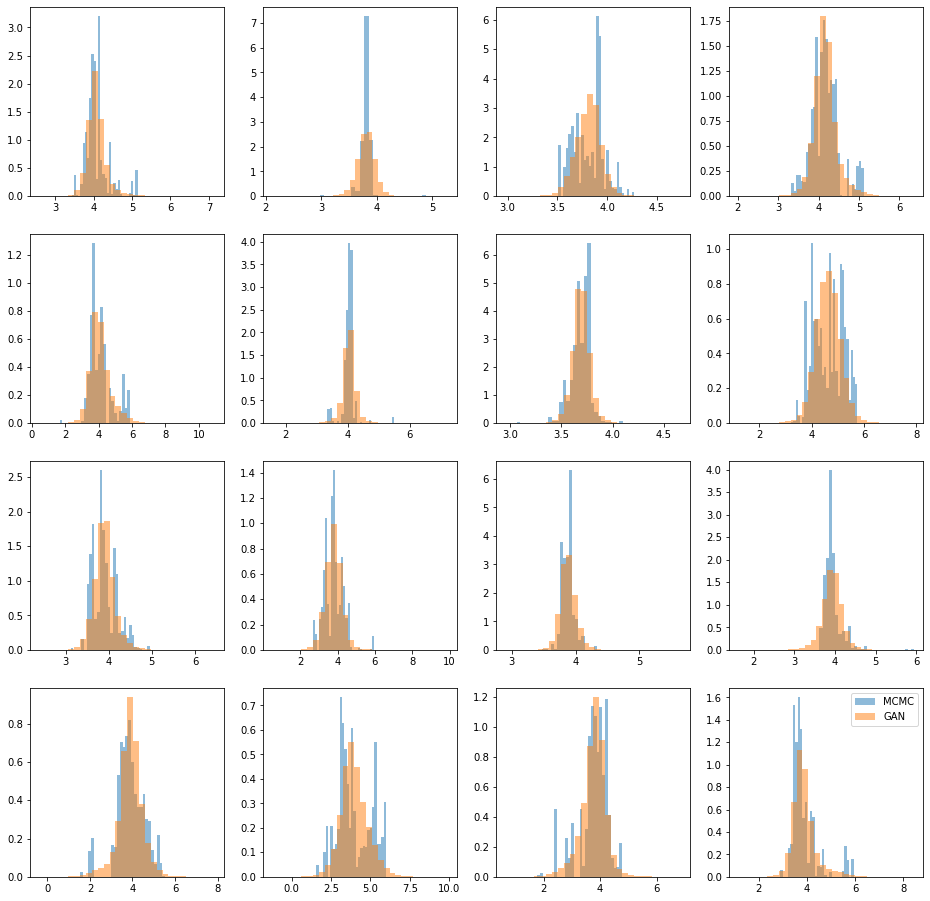

In [104]:
location_idxes = np.random.randint(low=0,high=2382,size=16)
fig,axes = plt.subplots(4,4,figsize=(16,16))
bins = 30
axes=axes.flatten()
for i,ax in enumerate(axes):
    ax.hist(data[:,location_idxes[i]],bins = 30,density=True,label='MCMC',alpha=0.5)
    ax.hist(fake_data_scaled[:,location_idxes[i]],bins = 30, density=True,label='GAN', alpha=0.5)
plt.legend()

In [105]:
# compute the EMD between locations
distance = np.zeros(2382)
for i in range(2382):
    distance[i] = EMD(data[:,i],fake_data_scaled[:,i])

/var/folders/hf/j0cnbrtd4fbcfm7nf1yyzbf40000gn/T/ipykernel_94530/1216910014.py:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


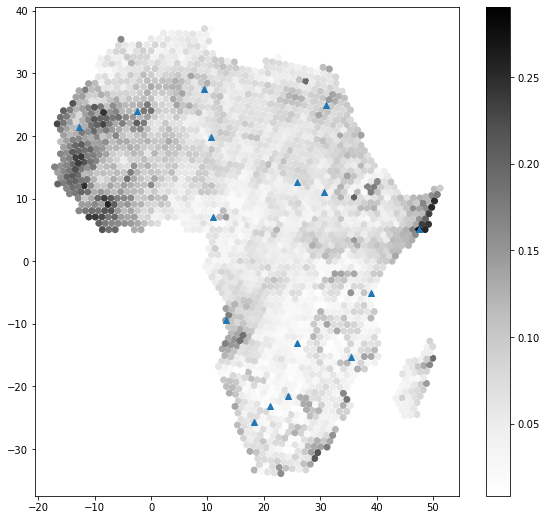

In [106]:
# plot locations
fig = plt.figure(figsize=(9.5,9))
plt.scatter(cord[:,0],cord[:,1],c=distance,cmap='Greys')
plt.colorbar()
plt.scatter(cord[location_idxes,0],cord[location_idxes,1],marker='^',cmap='RdBu')
plt.show()

(array([ 20.,  65.,  86., 125., 156., 202., 184., 205., 206., 184., 163.,
        126., 102., 104.,  66.,  64.,  49.,  50.,  39.,  17.,  16.,  21.,
         24.,  20.,  18.,  12.,  12.,  11.,   6.,   9.,   2.,   3.,   7.,
          2.,   4.,   1.,   0.,   0.,   0.,   1.]),
 array([0.0083007 , 0.01536172, 0.02242274, 0.02948375, 0.03654477,
        0.04360578, 0.0506668 , 0.05772781, 0.06478883, 0.07184984,
        0.07891086, 0.08597188, 0.09303289, 0.10009391, 0.10715492,
        0.11421594, 0.12127695, 0.12833797, 0.13539898, 0.14246   ,
        0.14952102, 0.15658203, 0.16364305, 0.17070406, 0.17776508,
        0.18482609, 0.19188711, 0.19894812, 0.20600914, 0.21307016,
        0.22013117, 0.22719219, 0.2342532 , 0.24131422, 0.24837523,
        0.25543625, 0.26249726, 0.26955828, 0.2766193 , 0.28368031,
        0.29074133]),
 <BarContainer object of 40 artists>)

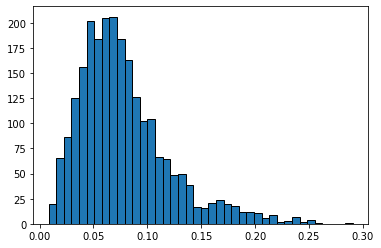

In [107]:
#plot the distribution of EMD
plt.hist(distance,bins=40,edgecolor="black")